In [94]:
import random
import pickle
import math
import scipy as sp
import scipy.stats as sps
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [95]:
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [96]:
model = SequenceModel(input_size=1657,
                      output_dim=1657,
                      hidden_size=128,
                      num_layers=1)

In [97]:
model.load_state_dict(torch.load( "ckpt/model.ckpt"))
model.eval()

SequenceModel(
  (lstm): LSTM(1657, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1657, bias=True)
)

In [98]:
with open("./ckpt/Z.pickle", "rb") as f:
    Z = pickle.load(f)
    
with open("./ckpt/scaler.pickle", "rb") as f:
    scaler = pickle.load(f)

In [99]:
# Prepare Data
def make_batch(data, batch_size, window_size, shuffle=True):
    window_list = []
    for i in range(len(data) - window_size - 1):
        window = data[i: i + window_size]
        window_list.append(window)

    if shuffle:
        random.shuffle(window_list)

    n_batch = math.ceil(len(window_list) / batch_size)
    batch_list = []
    for i in range(n_batch):
        batch = window_list[i*batch_size: (i+1)*batch_size]
        batch_list.append(batch)
    batch_list = np.array(batch_list)

    return batch_list

In [100]:
for_header = pd.read_csv("./Memory_metric_sort.csv", sep=',', index_col=False)
headers = list(for_header.keys())

In [101]:
########### anomaly detection #################
#1) put the newdata into the model

newdata = pd.read_csv("./MEM_100_0914.csv", sep=',', index_col=False)
newdata =newdata[headers]
newdata = newdata.to_numpy()

newdata = scaler.transform(newdata)

Z_newdata = []
window_size = 10
batch_size =192

reconstruction_error_new =[]

for i in range(len(newdata) - window_size - 1):
    batch_input = newdata[i: i + window_size]
    batch_input = torch.tensor(batch_input, dtype=torch.float32).unsqueeze(0)
    new_v, new_z = model(batch_input)
    Z_newdata.append(new_z.detach().numpy())
    reconstruction_error_new.append(torch.sum(torch.abs(new_v[:, :-1, :] - batch_input[:, 1:, :] )).item())

In [102]:
#2) Laading PDF value and get proability of error.

##Loading PDF value
f = open("./ckpt/pdf.txt", 'r')
line = f.readline()
rce_std, rce_mean  = line.split()
f.close()

In [103]:
##get proability of error.

# new_v: 1 x seq len x n feature

#Z = np.array(Z)
#하나씩 하는것과 나눠서 하는것 차이가없는지..

reconstruction_error_new = np.array(reconstruction_error_new, dtype=np.float)

rce_std = float(rce_std)
rce_mean = float(rce_mean)
print(rce_std,rce_mean)
rv = sps.norm(loc=rce_mean, scale=rce_std)
maxg = rv.pdf(rce_mean)
print('maxg', maxg)

252.80465737463186 745.8966310674494
maxg 0.001578065390663429


In [104]:
pdf = rv.logpdf(reconstruction_error_new)

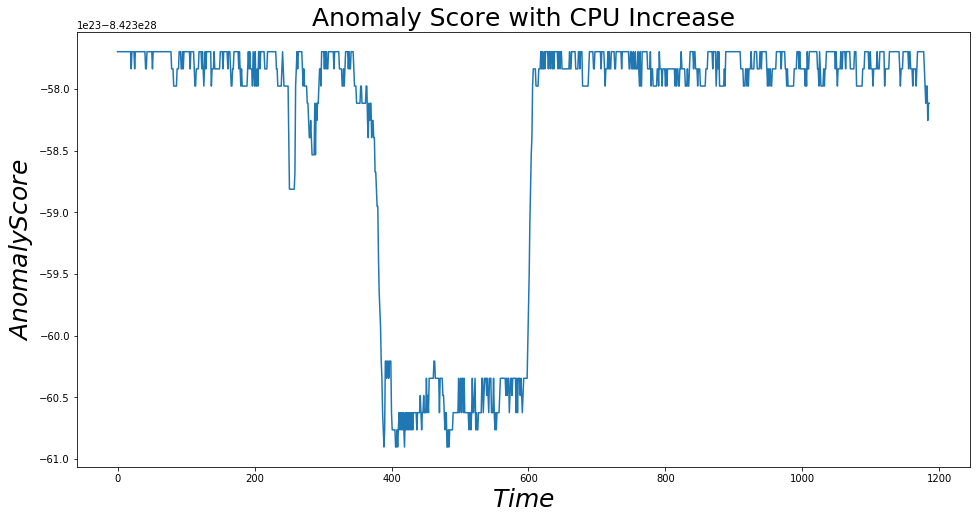

array([-8.42357696e+28, -8.42357696e+28, -8.42357696e+28, ...,
       -8.42358254e+28, -8.42358115e+28, -8.42358115e+28])

In [112]:
plt.figure(figsize=(16,8))
plt.plot(range(len(pdf)), pdf)

plt.title("Anomaly Score with CPU Increase", fontsize=25)
plt.xlabel("$Time$", fontsize=25)
plt.ylabel("$Anomaly Score$", fontsize=25)
plt.show()
pdf


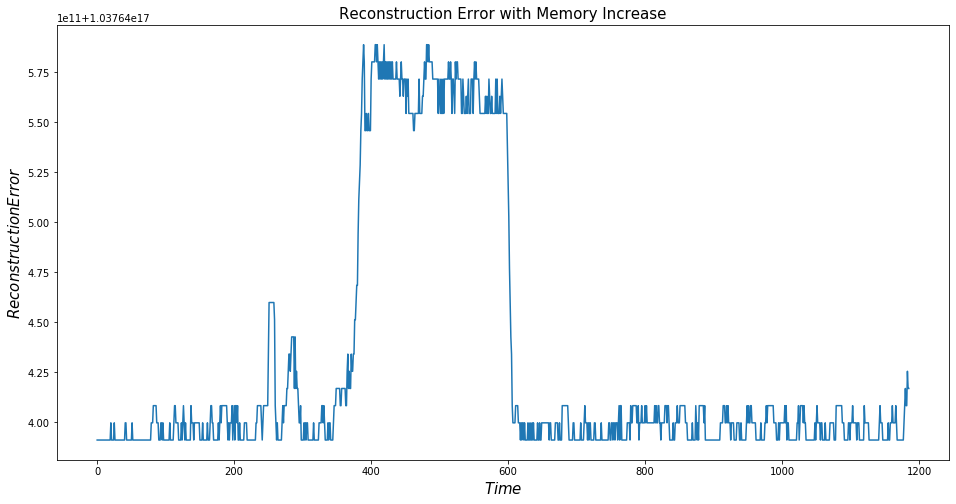

In [113]:
plt.figure(figsize=(16,8))
plt.plot(range(len(reconstruction_error_new)), reconstruction_error_new)
plt.title("Reconstruction Error with Memory Increase", fontsize=15)
plt.xlabel("$Time$", fontsize=15)
plt.ylabel("$Reconstruction Error$", fontsize=15)
plt.show()